# Cash Ratio Optimization

In [3]:
# Basic Math and data manipulation
import pandas as pd 
import numpy as np 

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Datetime object manipulation and Time series model
import datetime as dt
from statsmodels.tsa.stattools import adfuller as adf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import levene
from fbprophet import Prophet

# Plot styling
# 0 or False for Light mode
# 1 or True for Dark Mode

dark = 1

if dark:
    plt.style.use('dark_background')
else:
    plt.style.use('seaborn')

In [4]:
# Open Data
data = pd.read_csv('train.csv')
desc = pd.read_csv('data_description.csv')

# Set "periode" to Datetime object
data['periode'] = pd.to_datetime(data['periode'])

# Set "periode" to index and reindex date to get missing date
data = data.set_index('periode')
data = data.reindex(pd.date_range(start=data.index[0], end=data.index[-1]))
data = data.shift(1,freq='D')

# Make day column to get day in week
data['day'] = [i.weekday()+1 for i in data.index]

# Save missing date in variabel mising
missing = data[data['cash_in_echannel'].isna()].index

print('! Basic Information !')
print()
print('Rows'.ljust(10),':',data.shape[0],'Rows')
print('Columns'.ljust(10),':',data.shape[1],'Columns')
print('Missing'.ljust(10),':',len(missing),'Rows')
print('Start'.ljust(10),':',data.index[0])
print('End'.ljust(10),':',data.index[-1])

! Basic Information !

Rows       : 428 Rows
Columns    : 13 Columns
Missing    : 3 Rows
Start      : 2019-08-01 00:00:00
End        : 2020-10-01 00:00:00


In [5]:
print('! List Variabel !'.center(100))
print()

for i in range(12):
    print(desc.iloc[i,0].ljust(26),':',desc.iloc[i,2])

                                         ! List Variabel !                                          

cash_in_echannel           : Total Kas Masuk pada kas eChannel (ATM dan CRM)
cash_out_echannel          : Total Kas keluar pada kas eChannel (ATM dan CRM)
cash_in_kantor             : Total kas masuk pada kas kantor
cash_out_kantor            : Total kas keluar pada kas kantor
cr_ketetapan_total_bkn_sum : Maksimum cash ratio yang dii tetapkan kantor pusat
giro                       : Total simpanan giro
deposito                   : Total simpanan deposito
kewajiban_lain             : Simpanan selain giro tabungan dan deposito ,salah satunya adalah surat berharga yang diterbitkan
tabungan                   : Total simpanan tabungan
rata_dpk_mingguan          : rata - rata saldo DPK mingguan
kas_kantor                 : Total Dari kas kantor
kas_echannel               : Total dari kas eChannel


In [6]:
# Missing Value Treatment
data.iloc[:,2:4] = data.iloc[:,2:4].fillna(0)
data = data.ffill()

In [7]:
data.loc[missing,:]

,cash_in_echannel,cash_out_echannel,cash_in_kantor,cash_out_kantor,cr_ketetapan_total_bkn_sum,giro,deposito,kewajiban_lain,tabungan,rata_dpk_mingguan,kas_kantor,kas_echannel,day
2020-06-21,768600000.0,-582300000.0,0.0,0.0,3.0,6.044150e+11,9.073081e+11,1.067010e+10,6.881707e+11,2.771890e+11,8.519349e+12,2.711750e+09,7
2020-06-25,314900000.0,-535750000.0,0.0,0.0,3.0,5.770297e+11,8.491120e+11,1.150219e+10,6.800769e+11,2.769508e+11,8.447008e+12,2.450000e+09,4
2020-08-28,379700000.0,-627350000.0,0.0,0.0,3.0,8.834477e+11,8.358971e+11,1.459714e+10,7.333463e+11,2.898451e+11,1.040793e+13,4.652250e+09,5


# Normal Data

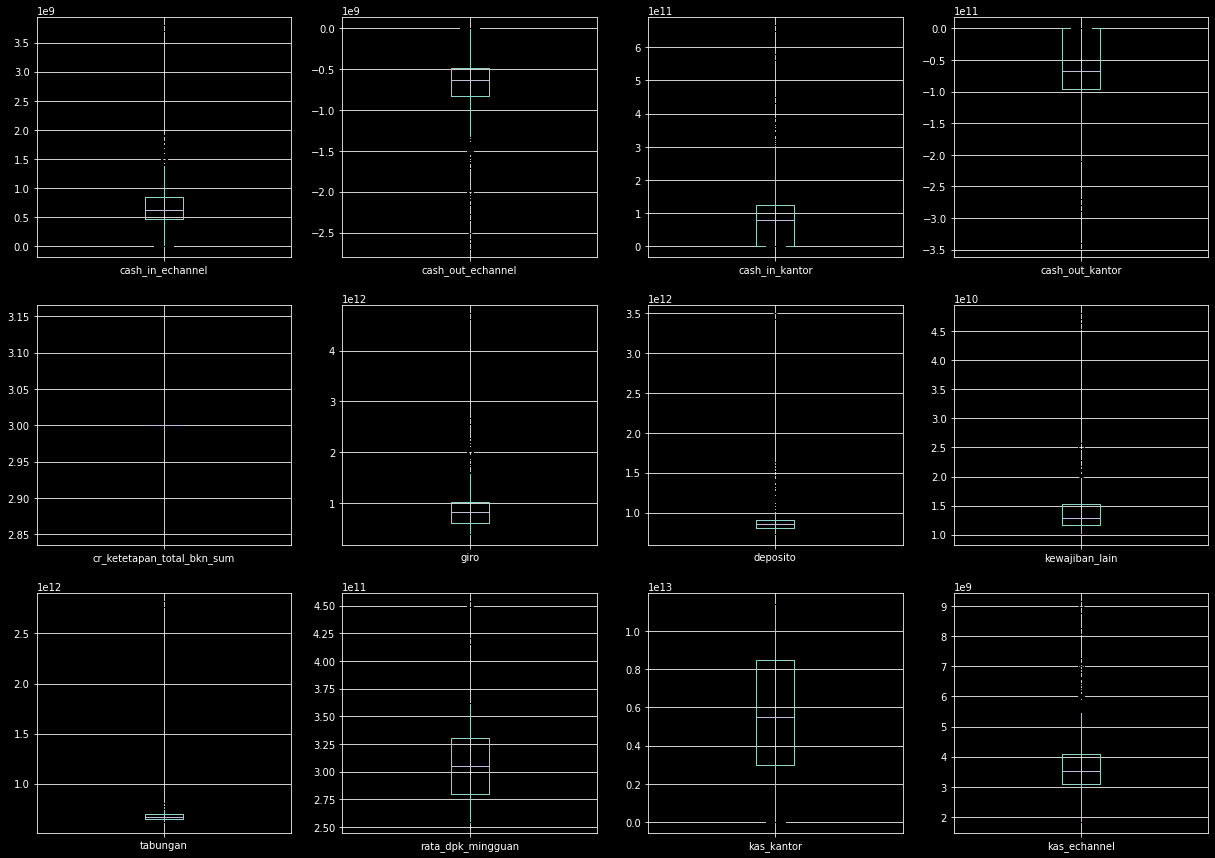

In [8]:
# Box Plot
plt.figure(figsize=(21,15))
for i in range(3):
    for j in range(4):
        plt.subplot(3,4, (i*4)+(j+1))
        data.boxplot(data.columns[(i*4)+j])

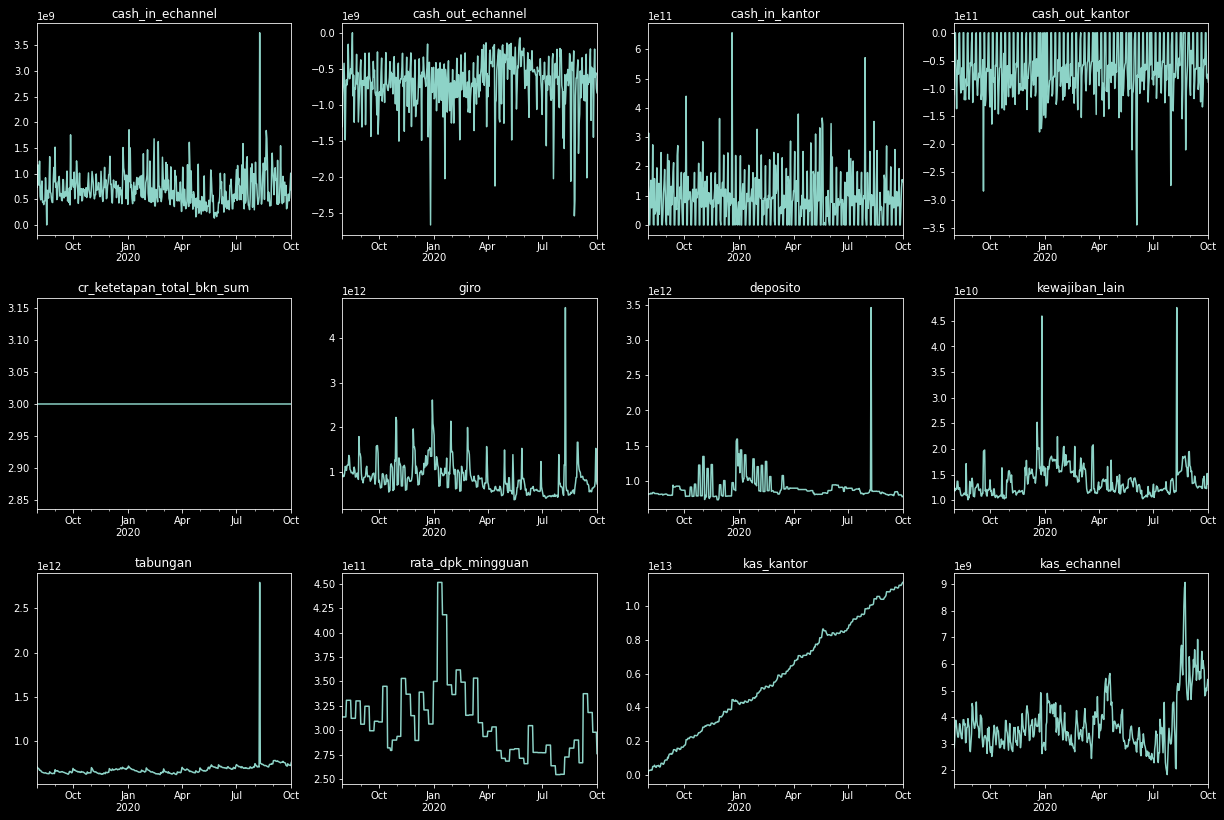

In [9]:
# Time Series Plot Data
plt.figure(figsize=(21,14))
for i in range(3):
    for j in range(4):
        plt.subplot(3,4,(i*4)+(j+1))
        data[data.columns[(i*4)+j]].plot(title=data.columns[(i*4)+j])
        plt.subplots_adjust(hspace=0.3)

In [10]:
# #Time Series Plot Bigger plot
# for i in range(12):
#     data.iloc[:,i].plot(title=data.columns[i], figsize=(21,6))
#     plt.show()

In [11]:
avg_str = []
avg_non_str = []
for i in range(12):
    if i != 4:
        result = adf(data.iloc[:,i])
        if result[1] <= 0.05:
            avg_str.append(data.columns[i])
        else:
            avg_non_str.append(data.columns[i])

In [12]:
def grouping(data,n):
    long = len(data)//n
    new_data = []
    for i in range(1,long+1):
        new_data.append(data[(i-1)*n:i*n].values)
    if i*n != len(data):
        new_data.append(data[i*n:].values)
    return new_data

In [13]:
var_str = []
var_non_str = []
for i in range(12):
    if i != 4:
        res = levene(*grouping(data.iloc[:,i],7))[1]
        if res > 0.05:
            var_str.append(data.columns[i])
        else:
            var_non_str.append(data.columns[i])

In [14]:
stationer = pd.DataFrame({'Variabel':data.columns[:-1], 
              'Average':[1 if i in avg_str else 0 for i in data.columns[:-1]],
              'Varians':[1 if i in var_str else 0 for i in data.columns[:-1]]})
stationer

,Variabel,Average,Varians
0,cash_in_echannel,0,1
1,cash_out_echannel,1,1
2,cash_in_kantor,1,1
3,cash_out_kantor,1,1
4,cr_ketetapan_total_bkn_sum,0,0
5,giro,1,0
6,deposito,1,0
7,kewajiban_lain,1,0
8,tabungan,1,1
9,rata_dpk_mingguan,0,0


# Data Differencing 1

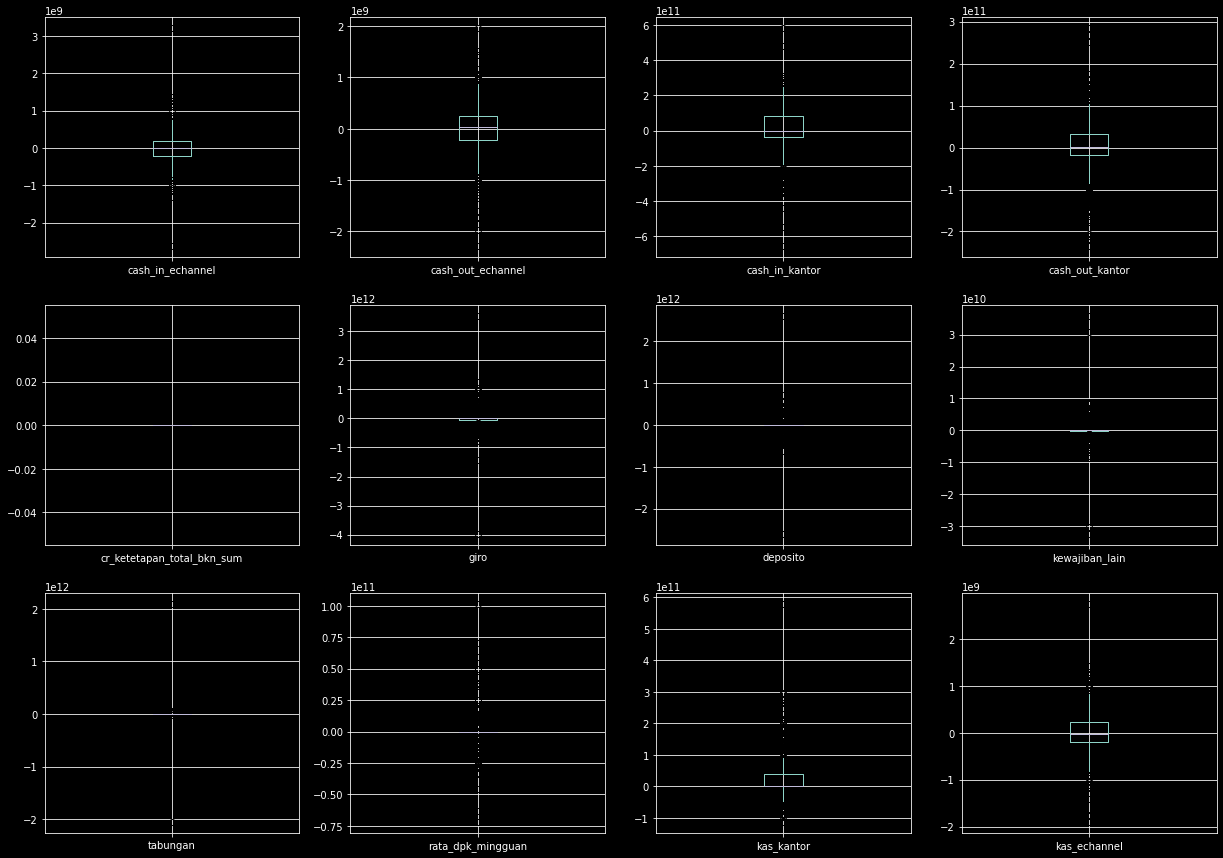

In [15]:
# Box Plot
plt.figure(figsize=(21,15))
for i in range(3):
    for j in range(4):
        plt.subplot(3,4, (i*4)+(j+1))
        data.diff().boxplot(data.columns[(i*4)+j])

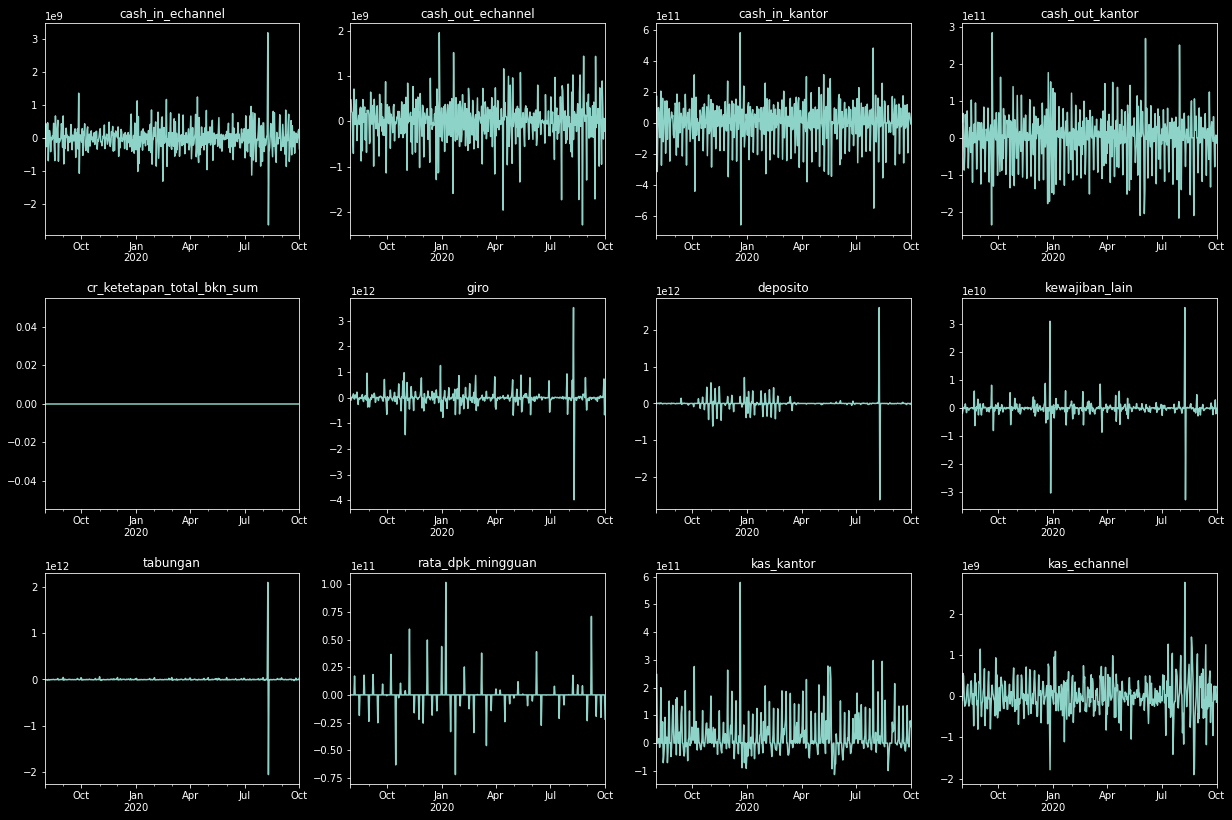

In [16]:
# Time series Plot Data Differencing(1)
plt.figure(figsize=(21,14))
for i in range(3):
    for j in range(4):
        plt.subplot(3,4,(i*4)+(j+1))
        data[data.columns[(i*4)+j]].diff().plot(title=data.columns[(i*4)+j])
        plt.subplots_adjust(hspace=0.3)

In [17]:
# Time Series Plot Bigger plot
# for i in range(12):
#     data.iloc[:,i].diff().plot(title=data.columns[i], figsize=(21,6))
#     plt.show()

In [18]:
avg_str = []
avg_non_str = []
for i in range(12):
    if i != 4:
        result = adf(data.iloc[:,i].diff()[1:])
        if result[1] <= 0.05:
            avg_str.append(data.columns[i])
        else:
            avg_non_str.append(data.columns[i])

In [19]:
var_str = []
var_non_str = []
for i in range(12):
    if i != 4:
        res = levene(*grouping(data.iloc[:,i].diff()[1:],7))[1]
        if res > 0.05:
            var_str.append(data.columns[i])
        else:
            var_non_str.append(data.columns[i])

In [20]:
stationer = pd.DataFrame({'Variabel':data.columns[:-1], 
              'Average':[1 if i in avg_str else 0 for i in data.columns[:-1]],
              'Varians':[1 if i in var_str else 0 for i in data.columns[:-1]]})
stationer

,Variabel,Average,Varians
0,cash_in_echannel,1,0
1,cash_out_echannel,1,1
2,cash_in_kantor,1,1
3,cash_out_kantor,1,1
4,cr_ketetapan_total_bkn_sum,0,0
5,giro,1,0
6,deposito,1,0
7,kewajiban_lain,1,0
8,tabungan,1,0
9,rata_dpk_mingguan,1,1


# Modelling

In [21]:
from fbprophet import Prophet

In [22]:
train_in_echannel = data.cash_in_echannel.reset_index()
train_out_echannel = data.cash_out_echannel.reset_index()
train_in_kantor = data.cash_in_kantor.reset_index()
train_out_kantor = data.cash_out_kantor.reset_index()

In [23]:
train_in_echannel.columns = ['ds','y']
train_out_echannel.columns = ['ds','y']
train_in_kantor.columns = ['ds','y']
train_out_kantor.columns = ['ds','y']

In [24]:
train_in_kantor.head()

,ds,y
0,2019-08-01,1.436722e+11
1,2019-08-02,3.144131e+11
2,2019-08-03,1.251294e+09
3,2019-08-04,0.000000e+00
4,2019-08-05,9.883331e+10


In [25]:
model_in_echannel = Prophet()
model_out_echannel = Prophet()
model_in_kantor = Prophet()
model_out_kantor = Prophet()

In [26]:
model_in_echannel.fit(train_in_echannel)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [27]:
model_out_echannel.fit(train_out_echannel)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [28]:
model_in_kantor.fit(train_in_kantor)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [29]:
model_out_kantor.fit(train_out_kantor)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [30]:
future = pd.DataFrame(pd.date_range('2020/10/02',periods=31),columns=['ds'])

In [34]:
predict_in_echannel = model_in_echannel.predict(future)['yhat']
predict_out_echannel = model_out_echannel.predict(future)['yhat']
predict_in_kantor = model_in_kantor.predict(future)['yhat']
predict_out_kantor = model_out_kantor.predict(future)['yhat']

In [49]:
predict_kas_echannel = [data['kas_echannel'][-1]]

for i in range(31):
    predict_kas_echannel.append(predict_in_echannel.iloc[i]+
                                predict_out_echannel.iloc[i]+
                                predict_kas_echannel[-1])
    
predict_kas_echannel = predict_kas_echannel[1:]

In [50]:
predict_kas_kantor = [data['kas_kantor'][-1]]

for i in range(31):
    predict_kas_kantor.append(predict_in_kantor.iloc[i]+
                              predict_out_kantor.iloc[i]+
                              predict_kas_kantor[-1])
    
predict_kas_kantor = predict_kas_kantor[1:]

In [55]:
test = pd.read_csv('test.csv')

In [56]:
test['value'] =  predict_kas_kantor + predict_kas_echannel

In [57]:
test.to_csv('submission.csv',index=False)